<a href="https://colab.research.google.com/github/prinaldi3/Denoising/blob/main/Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Installations and Imports

In [ ]:
!python -m pip install pip==21.0.1

     |████████████████████████████████| 1.5 MB 8.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [ ]:
!rm -rf xca
!git clone https://github.com/maffettone/xca

Cloning into 'xca'...
remote: Enumerating objects: 888, done.
remote: Counting objects: 100% (888/888), done.
remote: Compressing objects: 100% (525/525), done.
remote: Total 888 (delta 595), reused 625 (delta 360), pack-reused 0
Receiving objects: 100% (888/888), 218.62 KiB | 5.61 MiB/s, done.
Resolving deltas: 100% (595/595), done.


In [ ]:
%%bash
cd xca
python -m pip install .

Processing /content/xca
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for xca: filename=xca-0.post152+gc30f3f3-py3-none-any.whl size=84349 sha256=3f6dd505b8e6c8197fe7b456214e8a066518b6820ca939c52daf41ae9be6427c
  Stored in directory: /tmp/pip-ephem-wheel-cache-3gtv4xjh/wheels/e6/4c/ff/2cabe5dec6fa57a7d49e7fefa55ec45dbee5f3d24b3688706c
Successfully built xca


Training

In [ ]:
#Importing from XCA package

import xca
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from xca.ml.tf_models import build_CNN_encoder_model, build_CNN_decoder_model, VAE_denoising_training, VAE

In [ ]:
#Specify directories
dataset_paths = ['/content/gdrive/MyDrive/BaTiO_training/BTO_sim.tfrecord'] #alter this to change the dataset you're training on
out_dir = '/content/gdrive/MyDrive/BaTiO_training/training_1' #your training checkpoints will go here 

In [ ]:
#Build encoder/decoder networks using XCA methods

out_dir = '/content/gdrive/MyDrive/BaTiO_training/training_1' #saves training checkpoints to this directory
encoder, last_conv_shape = build_CNN_encoder_model(data_shape=(1750,1), 
                                                   latent_dim=100, 
                                                   dense_dims=[], 
                                                   filters=[32, 32, 16], 
                                                   kernel_sizes=[16, 16, 16], 
                                                   strides=[1, 1, 1], 
                                                   pool_sizes=[1, 1, 1], 
                                                   paddings=["same"]*3, 
                                                   verbose=False) #change this to True to see Keras.summary() of model

decoder = build_CNN_decoder_model(data_shape=(1750,1), 
                                  latent_dim=100, 
                                  last_conv_layer_shape=last_conv_shape, 
                                  filters = [16, 32, 32], 
                                  kernel_sizes=[16, 16, 16], 
                                  strides=[1, 1, 1], 
                                  paddings=["same"]*4, 
                                  verbose=False) 

In [ ]:
#Build the VAE and train!

kl_loss_factor = 0 #KL-Loss factor is set to 0 (we only care about reconstructions)
vae = VAE(encoder, decoder, kl_loss_factor) 
vae.built=True

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=1e-5)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

res = VAE_denoising_training(vae,
                            dataset_paths=dataset_paths,
                            out_dir=out_dir,
                            log_noise_min=log_noise_min,
                            log_noise_max=log_noise_max,
                            batch_size=64,
                            multiprocessing=16,
                            categorical=True,
                            data_shape=(1750, 1),
                            n_epochs=20,
                            optimizer=optimizer,
                            checkpoint_rate=100/20,
                            verbose=True
                            )


Model: "vae_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_encoder (Functional)     [(None, 100), (None, 100) 5625368   
_________________________________________________________________
CNN_decoder (Functional)     (None, 1750, 1)           100858502 
Total params: 106,483,870
Trainable params: 106,483,870
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: ignored

Plotting Results

In [ ]:
#Plot learning curves
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(res["reconstruction_loss"])
axs[0].set_title("reconstruction Loss")
axs[1].plot(res["kl_loss"])
axs[0].set_ylim((0,40))
axs[1].set_title("KL Loss")

In [ ]:
from xca.ml.tf_data_proc import build_dataset

#Build dataset
log_noise_min= -1 #controls degree of noise
log_noise_max= -.5

def preprocess(data, label):
    X = tf.cast(data, tf.float32)
    X = (X - tf.math.reduce_min(X, axis=0, keepdims=True)) / (
        tf.math.reduce_max(X, axis=0, keepdims=True)
        - tf.math.reduce_min(X, axis=0, keepdims=True)
    )
    noisy = tf.cast(data, tf.float32) + tf.random.normal(
        data.shape,
        stddev=10 ** np.random.uniform(log_noise_min, log_noise_max),
        dtype=tf.float32,
    )
    noisy = (noisy - tf.math.reduce_min(noisy, axis=0, keepdims=True)) / (
        tf.math.reduce_max(noisy, axis=0, keepdims=True)
        - tf.math.reduce_min(noisy, axis=0, keepdims=True)
    )
    return {"X": X, "X_noisy": noisy, "label": label}

dataset, _ = build_dataset(
    dataset_paths=dataset_paths,
    batch_size=1,
    multiprocessing=1,
    categorical=True,
    val_split=0.0,
    data_shape=(1750,1),
    # Preprocessing step adding noise and assuming probabilities needed on [0,1] and not on [-1,1]
    preprocess=preprocess
)


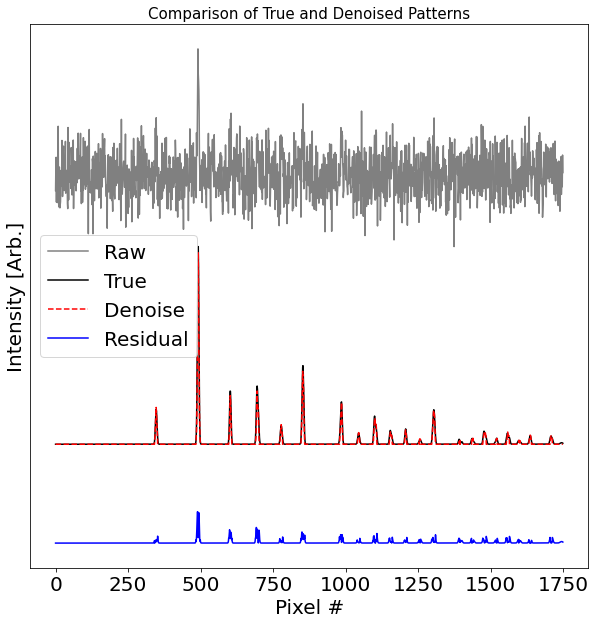

In [ ]:
#Plot reconstructions
i = 0
for batch in dataset:
  output = vae(batch["X_noisy"], training=False)
  X_denoise = output["reconstruction"][0]
  X = batch["X"][0]
  X_noisy = batch["X_noisy"][0]
  label = batch["label"][0]
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.plot(X_noisy+1.5, label="Raw", color='gray')
  ax.plot(X + .5, label="True", color='k')
  ax.plot(X_denoise+.5, 'r--', label="Denoise")
  ax.plot(abs(X-X_denoise), color='b', label="Residual")
  ax.set_title("Comparison of True and Denoised Patterns")
  ax.set_xlabel("Pixel #")
  ax.set_ylabel("Intensity [Arb.]")
  
  plt.rc('font', size=20)          # controls default text sizes
  plt.rc('axes', titlesize=30)     # fontsize of the axes title
  plt.rc('axes', labelsize=30)    # fontsize of the x and y labels

  ax.get_yaxis().set_ticks([])
  #fig.savefig('/content/gdrive/MyDrive/poster_figs/batio_reconstruction_2', facecolor='white')
  plt.legend()
  break